In [41]:
import keras
from keras import layers
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
#from tensorflow.keras.models import Model

import tensorflow as tf
# import keras routines from tensorflow
from tensorflow.keras import layers, models, activations, optimizers, callbacks, metrics

In [42]:
# function to calculate the smallest power of 2 equal to or greater than the input
def smallest_power_of_2(n):
    n -= 1  # Subtract 1 to ensure we handle powers of 2 correctly
    n |= n >> 1
    n |= n >> 2
    n |= n >> 4
    n |= n >> 8
    n |= n >> 16
    n += 1
    return n

In [43]:
def pad_to_next_power_of_2(matrix):
    # Calculate the new dimensions for height and width
    new_height = smallest_power_of_2(matrix.shape[0])
    new_width = smallest_power_of_2(matrix.shape[1])
    #new_width = smallest_power_of_2(matrix.shape[1])

    # Calculate the padding values
    vertical_pad = new_height - matrix.shape[0]
    horizontal_pad = new_width - matrix.shape[1]

    # Create a new matrix with the desired dimensions and pad the original matrix
    padded_matrix = np.pad(matrix, ((0, vertical_pad), (0, horizontal_pad)), mode='constant')

    return padded_matrix

In [44]:
def remove_padding(matrix, original_shape):
    if matrix.shape == original_shape:
        return matrix  # No padding to remove

    # remove padding from right and bottom
    h_orig, w_orig = original_shape
    h_padded, w_padded = matrix.shape

    if h_padded < h_orig or w_padded < w_orig:
        raise ValueError("Original shape is larger than the padded shape.")

    else :
         cropped_matrix = matrix[0:h_orig, 0:w_orig]
   
    return cropped_matrix

In [45]:
def ImagePreprocessing(image):
    # Convert the image to RGB (if it's in BGR format)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to a NumPy array
    img_array = np.array(img_rgb)

    # normalize image from 0 to 1
    img_normalized = img_rgb.astype('float32')/255.0
    
    RChannel = img_normalized[:,:,0]
    GChannel = img_normalized[:,:,1]
    BChannel = img_normalized[:,:,2]
    
    # Padding the image to a power of 2**
    R_power2_padded = pad_to_next_power_of_2(RChannel)
    G_power2_padded = pad_to_next_power_of_2(GChannel)
    B_power2_padded = pad_to_next_power_of_2(BChannel)
    
    h_new = R_power2_padded.shape[0]
    w_new = R_power2_padded.shape[1]

    RChannel_processed = np.reshape(R_power2_padded, (1, h_new, w_new, 1))
    GChannel_processed = np.reshape(G_power2_padded, (1, h_new, w_new, 1))
    BChannel_processed = np.reshape(B_power2_padded, (1, h_new, w_new, 1))
    
    
    image_RGB_matrix_processed = [RChannel_processed, GChannel_processed, BChannel_processed, h_new, w_new]

    return image_RGB_matrix_processed

In [46]:
def ChannelAnalysis(channel):
    print("Maximum value : ", np.max(channel))
    print("Minimum value : ",np.min(channel))
    # Flatten the matrix to 1D array
    values = channel.flatten()

    # Plot histogram
    plt.hist(values, bins=100, density=False, alpha=0.75, color='b')
    plt.title('Distribution of Values in the Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot heatmap
    plt.imshow(channel, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Add colorbar to show the mapping of values to colors
    plt.title('Heatmap of Channel Values')
    plt.show()
    
    return 1

def ChannelImageExtraction(image, channel):
    # Convert the image to RGB (if it's in BGR format)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to a NumPy array
    img_array = np.array(img_rgb)
    (height, width, channels) = img.shape
    
    ChannelPadding = np.zeros((height,width))
    
    if channel=='R':
        print("Channel Analysis : Original Red Channel")
        ChannelAnalysis(img_array[:,:,0])
        img_array[:,:,1] = ChannelPadding
        img_array[:,:,2] = ChannelPadding
    if channel=='G':
        print("Channel Analysis : Original Green Channel")
        ChannelAnalysis(img_array[:,:,1])
        img_array[:,:,0] = ChannelPadding
        img_array[:,:,2] = ChannelPadding
    if channel=='B':
        print("Channel Analysis : Original Blue Channel")
        ChannelAnalysis(img_array[:,:,2])
        img_array[:,:,0] = ChannelPadding
        img_array[:,:,1] = ChannelPadding
    
    return img_array

In [47]:
class ConvolutionalAutoencoder:
    def __init__(self, h, w):
        self.h = h
        self.w = w
        
        # define hyperparameters
        self.d = 25  # size of the reduced vector in the latent layer
        self.act = 'relu'  # activation function used in the convolution layers
        self.fs = (3, 3)  # filter size for the convolutional kernels
        self.ffs = (2, 2)  # filter size for max pooling
        self.st = (1, 1)  # strides for the convolution operation
        self.posrflatten = 0  # length before flatten
        self.preflattenshape = (0,0,0) # dimension before preflatten
        
        self.autoencoder = self.build_autoencoder()


    def build_autoencoder(self):
        # initialize the input layer with the shape of the data
        input_img = keras.Input(shape=(self.h, self.w, 1))

        # ENCODER
        # convolutional Layer with 64 kernels. padding is 'same' and activation function is ReLU.
        x = layers.Conv2D(32, self.fs, activation=self.act, strides=self.st, padding="same")(input_img)
        # max Pooling Layer to reduce dimensions
        x = layers.MaxPooling2D(self.ffs, padding="same")(x)
        
        # convolutional Layer with 64 kernels. padding is 'same' and activation function is ReLU.
        x = layers.Conv2D(64, self.fs, activation=self.act, strides=self.st, padding="same")(x)
        # second Max Pooling Layer
        x = layers.MaxPooling2D(self.ffs, padding='same')(x)

        # third Convolutional Layer with 128 kernels
        x = layers.Conv2D(128, self.fs, activation=self.act, strides=self.st, padding='same')(x)
        # third Max Pooling Layer
        x = layers.MaxPooling2D(self.ffs, padding='same')(x)

        # fourth Convolutional Layer with 256 kernels
        x = layers.Conv2D(256, self.fs, activation=self.act, strides=self.st, padding='same')(x)
        # fourth Max Pooling Layer
        x = layers.MaxPooling2D(self.ffs, padding='same')(x)
        self.preflattenshape = (x.shape[1], x.shape[2], x.shape[3])
        
        # flatten the output of the last Max Pooling Layer
        x = layers.Flatten()(x)
        self.postflattenlength = x.shape[1]
        
        # fully connected layer with 128 units and ReLU activation
        x = layers.Dense(128, activation=self.act)(x)
        
        # latent layer with 'd' dimensions
        encoded_img = layers.Dense(self.d)(x)

        x = layers.Dense(128, activation=self.act)(encoded_img)
        x = layers.Dense(self.postflattenlength, activation = self.act)(x)
        x = layers.Reshape(self.preflattenshape)(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(256, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(128, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(64, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(32, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        decoded_img = layers.Conv2D(1, self.fs, activation = 'sigmoid', strides = self.st, padding='same')(x)

        autoencoder = keras.Model(input_img, decoded_img)
        autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

        return autoencoder
    
    def train(self, data, epochs=50):
        self.autoencoder.fit(data, data, epochs=epochs, verbose=0)
        
    def encode(self,data):
        encoded_data = self.autoencoder.layers[0](data)
        encoded_data = self.autoencoder.layers[1](encoded_data)
        encoded_data = self.autoencoder.layers[2](encoded_data)
        encoded_data = self.autoencoder.layers[3](encoded_data)
        encoded_data = self.autoencoder.layers[4](encoded_data)
        encoded_data = self.autoencoder.layers[5](encoded_data)
        encoded_data = self.autoencoder.layers[6](encoded_data)
        encoded_data = self.autoencoder.layers[7](encoded_data)
        encoded_data = self.autoencoder.layers[8](encoded_data)
        encoded_data = self.autoencoder.layers[9](encoded_data)
        encoded_data = self.autoencoder.layers[10](encoded_data)
        encoded_data = self.autoencoder.layers[11](encoded_data)
        return encoded_data


    def decode(self, encoded_data):
        decoded_data = self.autoencoder.layers[-12](encoded_data)
        decoded_data = self.autoencoder.layers[-11](decoded_data)
        decoded_data = self.autoencoder.layers[-10](decoded_data)
        decoded_data = self.autoencoder.layers[-9](decoded_data)
        decoded_data = self.autoencoder.layers[-8](decoded_data)
        decoded_data = self.autoencoder.layers[-7](decoded_data)
        decoded_data = self.autoencoder.layers[-6](decoded_data)
        decoded_data = self.autoencoder.layers[-5](decoded_data)
        decoded_data = self.autoencoder.layers[-4](decoded_data)
        decoded_data = self.autoencoder.layers[-3](decoded_data)
        decoded_data = self.autoencoder.layers[-2](decoded_data)
        decoded_data = self.autoencoder.layers[-1](decoded_data)
        return decoded_data

    def summary(self):
        self.autoencoder.summary()

In [48]:
img = cv2.imread('/kaggle/input/sm2001-project-q4-dataset/KTH_photo reduced 5.jpg')
(orig_h, orig_w, channels) = img.shape

[RChannel, GChannel, BChannel, h, w] = ImagePreprocessing(img)

In [49]:
# Create an instance of the Autoencoder class
autoencoderModel_RChannel = ConvolutionalAutoencoder(h,w)
autoencoderModel_GChannel = ConvolutionalAutoencoder(h,w)
autoencoderModel_BChannel = ConvolutionalAutoencoder(h,w)

autoencoderModel_RChannel.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_81 (Conv2D)          (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 256, 256, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 128, 128, 128)     7385

In [50]:
epochs = 50



# Train the Red Channel Convolution AE
print("Training the Red Channel Convolution AutoEncoder")
progress = tqdm(range(epochs))
lossRecords_RChannel = np.zeros(epochs)

for epoch in progress:
    p = autoencoderModel_RChannel.autoencoder.predict(RChannel, verbose=0)
    loss_val = autoencoderModel_RChannel.autoencoder.evaluate(RChannel, RChannel, verbose=0)
    lossRecords_RChannel[epoch] = loss_val

    autoencoderModel_RChannel.autoencoder.fit(RChannel, RChannel, epochs=1, verbose=0)

    # Update the progress bar
    progress.set_description(f"Epoch {epoch} | Loss {loss_val:.8f}")

    
# Train the Green Channel Convolution AE
print("Training the Green Channel Convolution AutoEncoder")
progress = tqdm(range(epochs))
lossRecords_GChannel = np.zeros(epochs)

for epoch in progress:
    p = autoencoderModel_GChannel.autoencoder.predict(GChannel, verbose=0)
    loss_val = autoencoderModel_GChannel.autoencoder.evaluate(GChannel, GChannel, verbose=0)
    lossRecords_GChannel[epoch] = loss_val

    autoencoderModel_GChannel.autoencoder.fit(GChannel, GChannel, epochs=1, verbose=0)

    # Update the progress bar
    progress.set_description(f"Epoch {epoch} | Loss {loss_val:.8f}")
    
    
# Train the Blue Channel Convolution AE
print("Training the Blue Channel Convolution AutoEncoder")
progress = tqdm(range(epochs))
lossRecords_BChannel = np.zeros(epochs)

for epoch in progress:
    p = autoencoderModel_BChannel.autoencoder.predict(BChannel, verbose=0)
    loss_val = autoencoderModel_BChannel.autoencoder.evaluate(BChannel, BChannel, verbose=0)
    lossRecords_BChannel[epoch] = loss_val

    autoencoderModel_BChannel.autoencoder.fit(BChannel, BChannel, epochs=1, verbose=0)

    # Update the progress bar
    progress.set_description(f"Epoch {epoch} | Loss {loss_val:.8f}")
    


Training the Red Channel Convolution AutoEncoder


Epoch 49 | Loss 0.23278454: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it]


Training the Green Channel Convolution AutoEncoder


Epoch 49 | Loss 0.25255993: 100%|██████████| 50/50 [04:04<00:00,  4.88s/it]


Training the Blue Channel Convolution AutoEncoder


Epoch 49 | Loss 0.16761439: 100%|██████████| 50/50 [04:09<00:00,  5.00s/it]


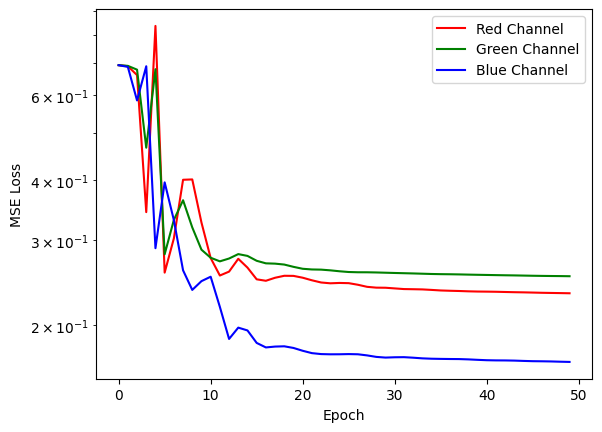

In [51]:
plt.semilogy(range(epochs), lossRecords_RChannel, color='red', label='Red Channel')
plt.semilogy(range(epochs), lossRecords_GChannel, color='green', label='Green Channel')
plt.semilogy(range(epochs), lossRecords_BChannel, color='blue', label='Blue Channel')


# Adding labels and legend
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Show the plot
plt.show()

In [52]:
def ReconstructChannel(AEmodel, ChannelData_Vec, orig_h, orig_w):
    # Encode the channel data
    encodedData = AEmodel.encode(ChannelData_Vec)
    # Decode the encoded data
    decodedData = AEmodel.decode(encodedData)
    
    # Reshape the decoded Channel data back to the original shape
    decodedData_reshaped = np.squeeze(decodedData.numpy())
    
    # Rescale Channel Data    
    ChannelLayer = decodedData_reshaped*255
    
    return [encodedData.numpy(), decodedData.numpy(), ChannelLayer]

In [53]:
[encodedData_RChannel, decodedData_RChannel, RChannel] = ReconstructChannel(
                                                 AEmodel = autoencoderModel_RChannel,
                                                 ChannelData_Vec = RChannel, orig_h = h, orig_w = w)

[encodedData_GChannel, decodedData_GChannel, GChannel] = ReconstructChannel(
                                                 AEmodel = autoencoderModel_GChannel,
                                                 ChannelData_Vec = GChannel, orig_h = h, orig_w = w)

[encodedData_BChannel, decodedData_BChannel, BChannel] = ReconstructChannel(
                                                 AEmodel = autoencoderModel_BChannel,
                                                 ChannelData_Vec = BChannel, orig_h = h, orig_w = w)

Original Red Channel
Channel Analysis : Original Red Channel
Maximum value :  255
Minimum value :  0


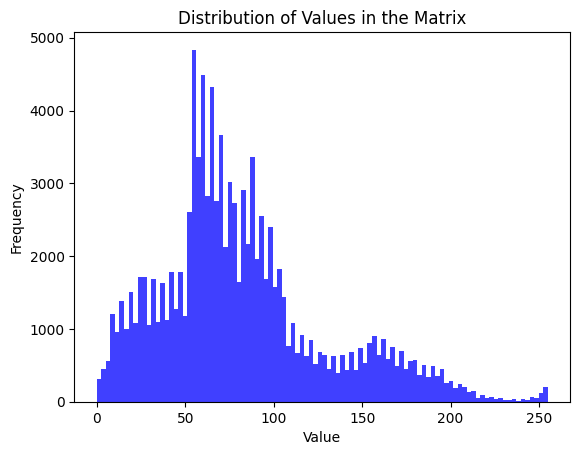

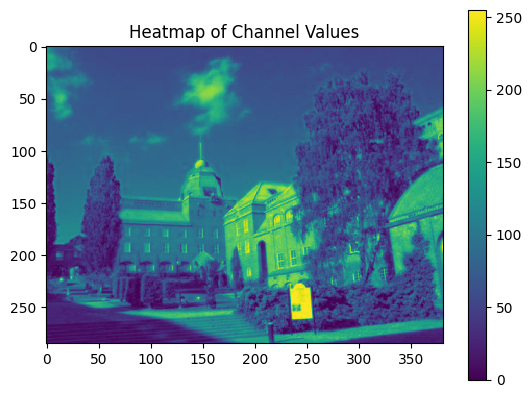

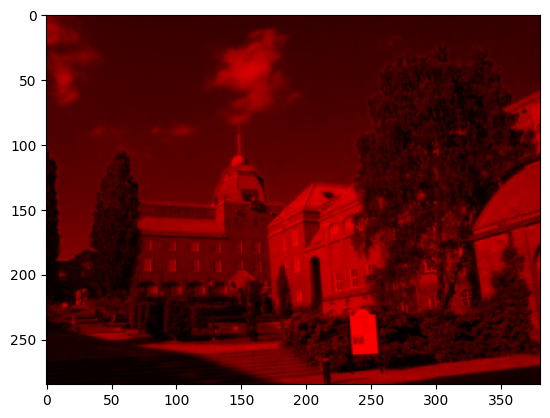

Reconstructed Red Channel
Maximum value :  252.40355
Minimum value :  0.27174392


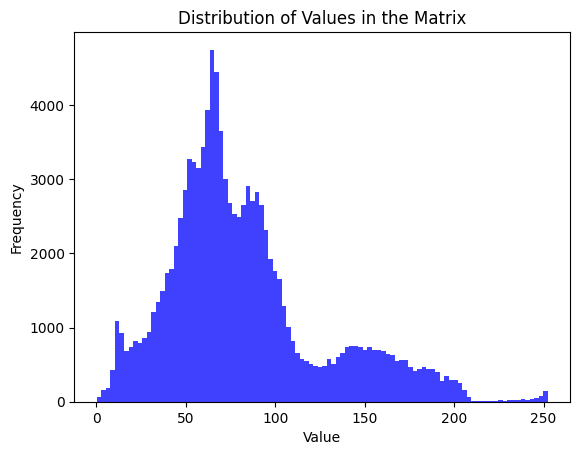

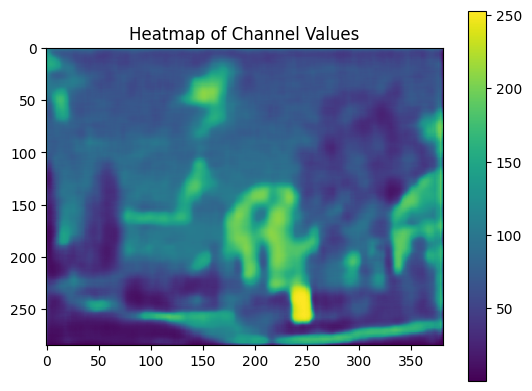

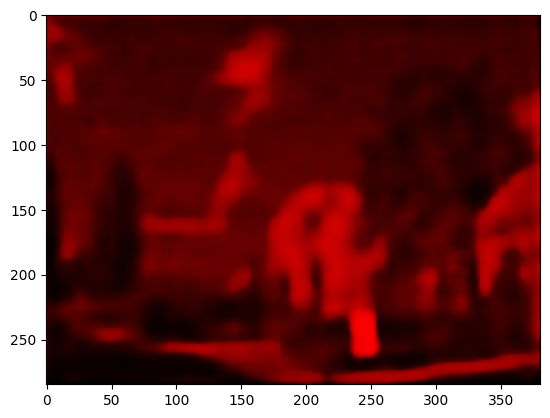

Original Green Channel
Channel Analysis : Original Green Channel
Maximum value :  255
Minimum value :  0


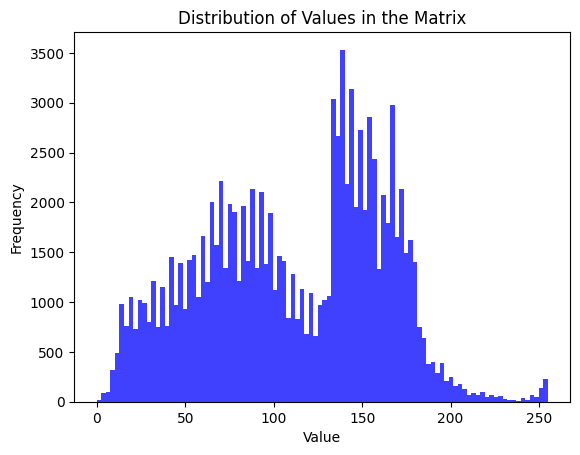

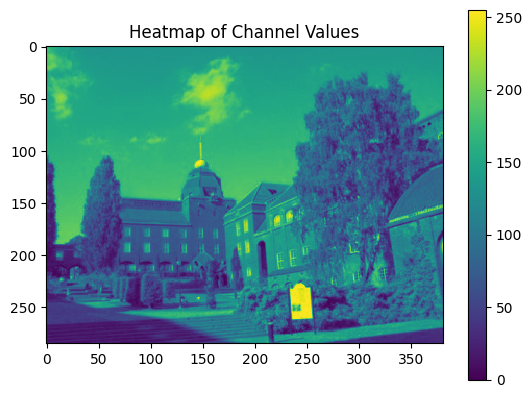

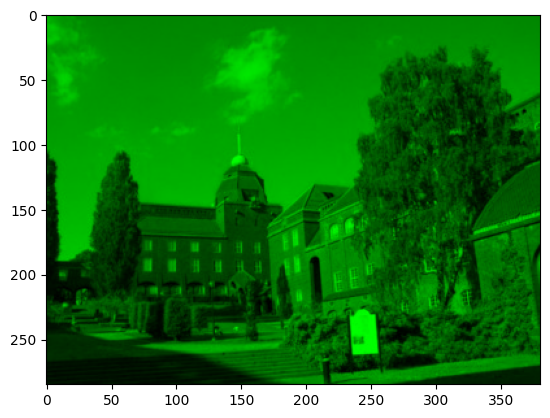

Reconstructed Green Channel
Maximum value :  254.02164
Minimum value :  3.9150655


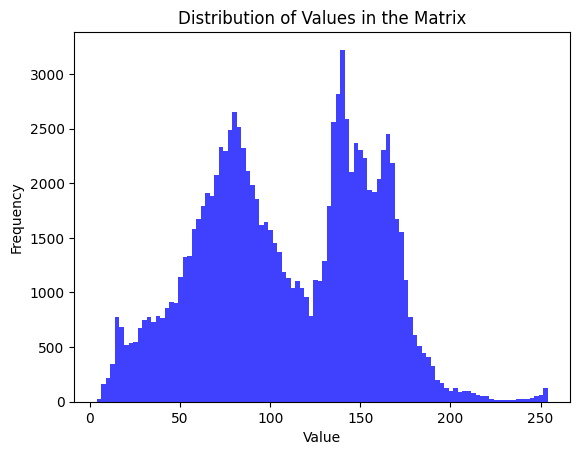

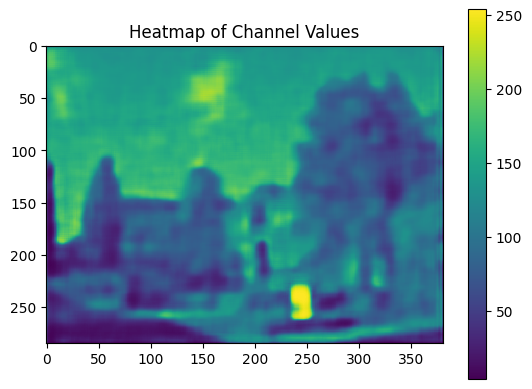

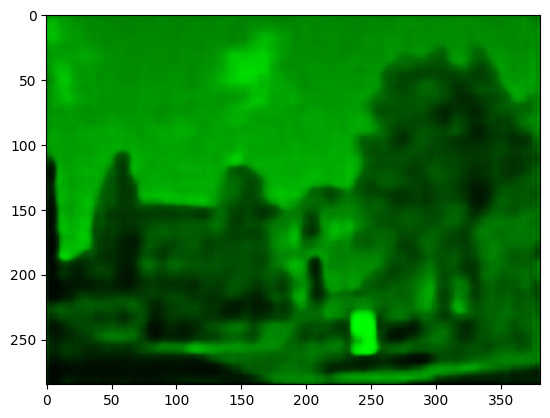

Original Blue Channel
Channel Analysis : Original Blue Channel
Maximum value :  255
Minimum value :  0


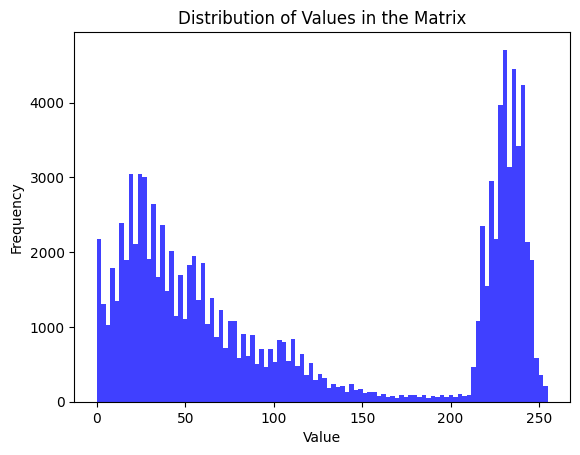

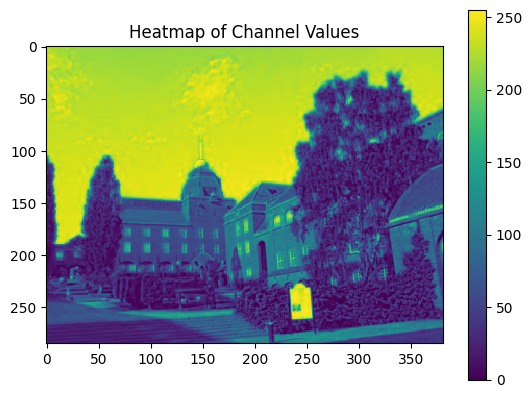

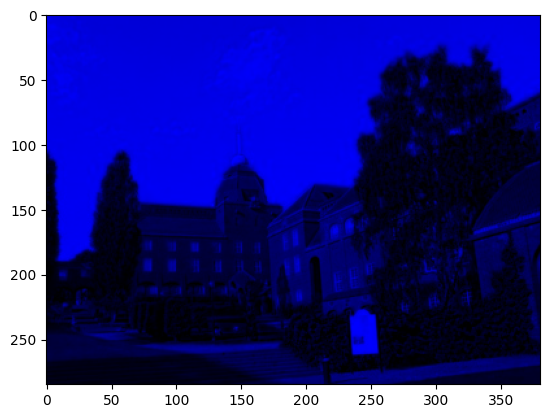

Reconstructed Blue Channel
Maximum value :  253.26857
Minimum value :  3.227837


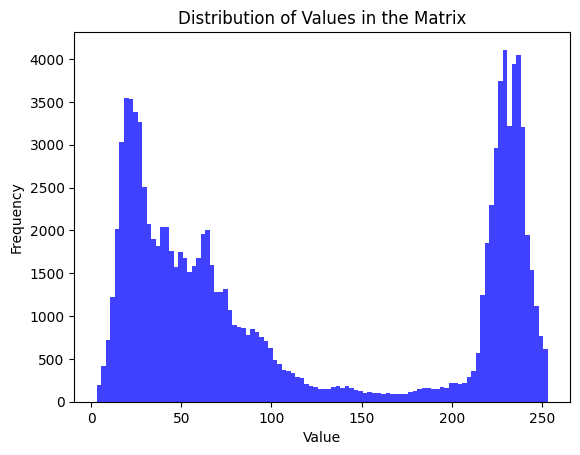

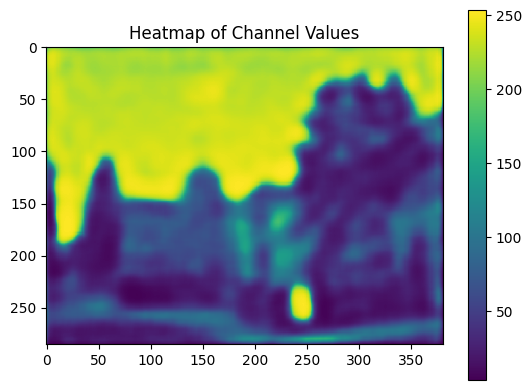

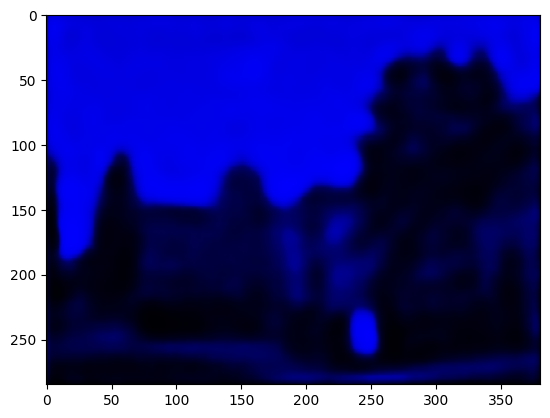

In [54]:
ChannelPadding = np.zeros((orig_h,orig_w))

# Red Channel
print("Original Red Channel")
Original_RChannel_Image = ChannelImageExtraction(img,'R') # includes analysis
plt.imshow(Original_RChannel_Image)
plt.show()

print("Reconstructed Red Channel")
RChannel_unpadded = remove_padding(RChannel, (orig_h,orig_w))
ChannelAnalysis(RChannel_unpadded)
reconstructed_RChannel_Image = np.dstack((RChannel_unpadded, ChannelPadding, ChannelPadding))
plt.imshow(reconstructed_RChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()

# Green Channel
print("Original Green Channel")
Original_GChannel_Image = ChannelImageExtraction(img,'G') # includes analysis
plt.imshow(Original_GChannel_Image)
plt.show()

print("Reconstructed Green Channel")
GChannel_unpadded = remove_padding(GChannel, (orig_h,orig_w))
ChannelAnalysis(GChannel_unpadded)
reconstructed_GChannel_Image = np.dstack((ChannelPadding, GChannel_unpadded, ChannelPadding))
plt.imshow(reconstructed_GChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()

# Blue Channel
print("Original Blue Channel")
Original_BChannel_Image = ChannelImageExtraction(img,'B') # includes analysis
plt.imshow(Original_BChannel_Image)
plt.show()

print("Reconstructed Blue Channel")
BChannel_unpadded = remove_padding(BChannel, (orig_h,orig_w))
ChannelAnalysis(BChannel_unpadded)
reconstructed_BChannel_Image = np.dstack((ChannelPadding, ChannelPadding, BChannel_unpadded))
plt.imshow(reconstructed_BChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()


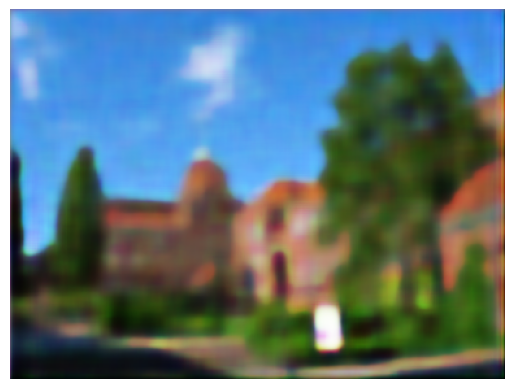

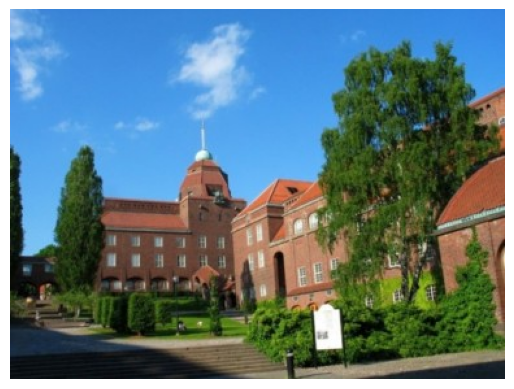

In [55]:
# Recombine the channels into one RGB matrix
reconstructed_rgb_image = np.dstack((RChannel_unpadded, GChannel_unpadded, BChannel_unpadded))

# Display the recombined image
plt.imshow(reconstructed_rgb_image.astype('uint8'))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Display original image to compare
plt.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).astype('uint8'))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()